In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import string
from tqdm import tqdm
import re
import random
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset

In [2]:
token_dict = {letter:i for letter,i in zip(string.ascii_lowercase, range(1,27))}
token_dict[' '] = 0
token_dict['\n'] = 27

class TextDataset(Dataset):
    def __init__(self, sentences, idx):
        self.data = []

        self.max_len = max([len(x) for x in sentences])

        for sentence in sentences:
            if len(sentence) > idx:
                x = torch.tensor([token_dict[x] for x in sentence[:idx]], dtype=torch.int64, device=device)
                y = torch.tensor(token_dict[sentence[idx]], dtype=torch.int64, device=device)
                self.data.append((x, y))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

In [3]:
sentences_file = 'sentences.txt'

In [4]:
allowed_chars = set(string.ascii_lowercase + ' \n')

In [5]:
sentences = []
with open(sentences_file, 'r') as f:
    sentences = f.readlines()
sentences = [x.replace('\'', '') for x in sentences]
sentences = [re.sub('\W+', ' ', x.lower()).strip() for x in sentences]

sentences = list(set(sentences))

In [6]:
## Length of alphabet used
print(len(list(set(''.join(sentences)))))

## Number of unique words
print(len(list(' '.join(sentences).split(' '))))
print(len(list(set(' '.join(sentences).split(' ')))))

31
42222
3352


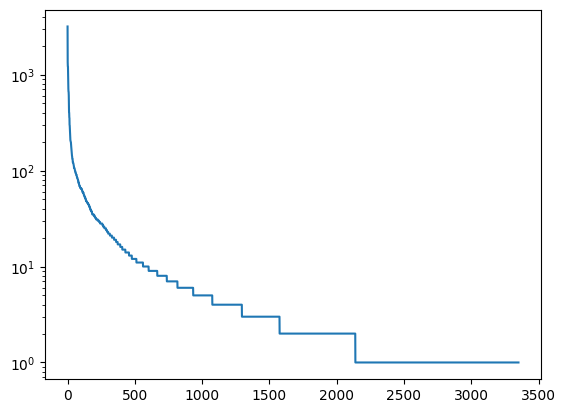

In [7]:
plt.plot(pd.DataFrame(list(' '.join(sentences).split(' '))).value_counts().values)
plt.yscale('log')

In [8]:
map_dict = {x[0]:y for x,y in 
            pd.DataFrame(list(' '.join(sentences).split(' ')))\
                .value_counts().to_dict().items()}

common_sentences = []

for sentence in sentences:
    good = True

    for word in sentence.split(' '):
        if map_dict[word] < 10:
            good = False
            break

    for char in sentence:
        if char not in allowed_chars:
            good = False
            break
    
    if good:
        common_sentences.append(sentence + '\n')

random.shuffle(common_sentences)

In [9]:
## Length of alphabet used
print(len(list(set(''.join(common_sentences)))))

## Number of unique words
print(len(list(' '.join(common_sentences).split(' '))))
print(len(list(set(' '.join(common_sentences).split(' ')))))

28
17294
1021


## Model

In [11]:
class GRUTextGenerator(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout_prob=0.1):
        super(GRUTextGenerator, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        
        self.embedding_ff = nn.Linear(vocab_size, embed_size, bias=False)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer
        
        self.gru1 = nn.GRU(embed_size, hidden_size, 1, batch_first=True)
        self.gru2 = nn.GRU(hidden_size, hidden_size, 1, batch_first=True)
        self.gru3 = nn.GRU(hidden_size, hidden_size, 1, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # x: (batch_size, seq_length)
        x = torch.nn.functional.one_hot(x, num_classes=self.vocab_size).float()
        embedded = self.embedding_ff(x)
        embedded = self.dropout(embedded)  # Apply dropout to the embedded input
        
        x, hidden1 = self.gru1(embedded, hidden)  # Optionally pass hidden state
        x = self.dropout(x)  # Apply dropout after first GRU
        
        x, hidden2 = self.gru2(x, hidden1) 
        x = self.dropout(x)  # Apply dropout after second GRU
        
        x, hidden3 = self.gru3(x, hidden2)
        x = self.dropout(x)  # Apply dropout after third GRU
        
        logits = self.fc(x)  # (batch_size, seq_length, vocab_size)
        return logits, hidden3


In [12]:
# Example hyperparameters
vocab_size = 28  # a-z and space, \n chars
embed_size = 256
hidden_size = 512
batch_size = 64

# Create the model
model = GRUTextGenerator(vocab_size, embed_size, hidden_size)

In [15]:
def load_model(model, model_path, device):
    # Load the saved model state dictionary
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")

load_model(model, 'model_cache/model_epoch_41.pt', device)

Model loaded from model_cache/model_epoch_41.pt


## Training

In [16]:
def train(model, dataloaders, vocab_size, device, epochs=10, startepoch=0, lr=0.0001, save_dir='model_cache'):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.to(device)
    model.train()

    # Ensure the save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for epoch in range(startepoch, epochs):
        total_loss = 0
        for data_loader in dataloaders:
            for _, (inputs, targets) in enumerate(data_loader, 0):
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                
                logits, _ = model(inputs)  # (batch_size, seq_length, vocab_size)
                logits = logits[:, -1, :]
                logits = logits.view(-1, vocab_size)  # Reshape for loss calculation
                targets = targets.view(-1)  # Reshape to match logits
                
                loss = criterion(logits, targets)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss}")

        # Save the model after each epoch
        model_path = os.path.join(save_dir, f'model_epoch_{epoch+1}.pt')
        torch.save(model.state_dict(), model_path)
        # print(f"Model saved to {model_path}")


In [17]:
dataloaders = []
for i in range(1, max([len(x) for x in common_sentences])):
    dataset = TextDataset(common_sentences, i)
    dataloaders.append(DataLoader(dataset, batch_size))

train(model, dataloaders, vocab_size, device, epochs=60, startepoch=42)

Epoch 43/60, Loss: 634.1374777057208


KeyboardInterrupt: 

In [ ]:
dataloaders = []
for i in range(1, max([len(x) for x in common_sentences])):
    dataset = TextDataset(common_sentences, i)
    dataloaders.append(DataLoader(dataset, batch_size))

train(model, dataloaders, vocab_size, device, epochs=60, startepoch=30)

Epoch 1/30, Loss: 608.1454376026813
Epoch 2/30, Loss: 563.2294858114619
Epoch 3/30, Loss: 544.8194607591286
Epoch 4/30, Loss: 529.7589799932903
Epoch 5/30, Loss: 515.4921694583754
Epoch 6/30, Loss: 502.8573411722464
Epoch 7/30, Loss: 490.9804561040073
Epoch 8/30, Loss: 480.8322412063717
Epoch 9/30, Loss: 471.6131476057344
Epoch 10/30, Loss: 463.9399711136939
Epoch 11/30, Loss: 457.81447389251844
Epoch 12/30, Loss: 453.3699862015201
Epoch 13/30, Loss: 449.7135527845239
Epoch 14/30, Loss: 446.9867386568949
Epoch 15/30, Loss: 445.03602773435705
Epoch 16/30, Loss: 443.9416082640746
Epoch 17/30, Loss: 442.7421854867789
Epoch 18/30, Loss: 442.38801891756884
Epoch 19/30, Loss: 442.86027276951063
Epoch 20/30, Loss: 442.71631350391544
Epoch 21/30, Loss: 441.7902618972148
Epoch 22/30, Loss: 440.5920065352693
Epoch 23/30, Loss: 437.9726842156233
Epoch 24/30, Loss: 434.216297050094
Epoch 25/30, Loss: 431.9342754115496
Epoch 26/30, Loss: 430.6583996892441
Epoch 27/30, Loss: 429.9540345290152
Epoch 

# Inference

In [ ]:
def vectorise(sentence):
    return torch.tensor([token_dict[x] for x in sentence], dtype=torch.int64, device=device)

def softmax(logits, temperature=1.0):
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits - np.max(scaled_logits))
    probs = exp_logits / exp_logits.sum()
    return probs

def run_inference(model, sentence, temperature=1.0):
    model.eval()

    input = vectorise(sentence)

    output = model(input)

    logits = output[0][-1, :].detach().numpy()

    # print(logits)

    # # Compute probabilities using softmax with temperature
    # probs = softmax(logits, temperature)

    # # Randomly sample from the probability distribution
    # sampled_idx = np.random.choice(len(probs), p=probs)

    sampled_idx = np.argmax(logits)
    # print(sampled_idx)

    # Find the corresponding token
    for a, i in token_dict.items():
        if sampled_idx == i:
            sentence += a
            return sentence

In [36]:
sentence = random.sample(string.ascii_lowercase, 1)[0]
sentence = 'c'
print(sentence, end='')

while sentence[-1] != '\n':
    sentence = run_inference(model, sentence, temperature=0.6)
    print(sentence[-1], end='')

can i see this you always


In [37]:
import numpy as np
import json
from json import JSONEncoder


In [38]:
class EncodeTensor(JSONEncoder,Dataset):
    def default(self, obj):
        if isinstance(obj, torch.Tensor):
            return obj.cpu().detach().numpy().tolist()
        return super(json.NpEncoder, self).default(obj)


In [ ]:
# x = vectorise(sentence)
# y = model(x)[0]

# np.savetxt('test_data/generative_gru_x.csv', x.detach(), delimiter=',')
# np.savetxt('test_data/generative_gru_y.csv', y.detach(), delimiter=',')

with open('models/generative_gru.json', 'w') as json_file:
    json.dump(model.state_dict(), json_file,cls=EncodeTensor)